# Build wavelet

Edited by Louise, 28-02-2023

Show how to load wavelets from s2wav.

In [7]:
from jax import jit, config

import s2fft

config.update("jax_enable_x64", True)

import numpy as np
from matplotlib import pyplot as plt
from importlib import reload

import scatcovjax.plotting as plot

import s2wav
from s2wav.filter_factory.filters import filters_directional_vectorised
from s2wav.filter_factory.filters import filters_axisym_vectorised

plot.notebook_plot_format()

# Make axisymmetric wavelets

In [ ]:
sampling = "mw"
multiresolution = True
reality = True

L = 32
J_min = 0

(<Figure size 800x600 with 1 Axes>, <Axes: >)

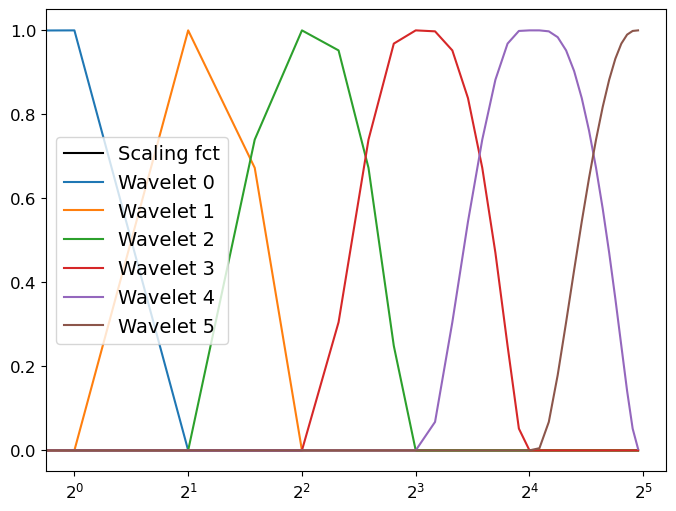

In [3]:
filters = filters_axisym_vectorised(L, J_min)

# Plot the filters
plot.plot_filters(filters, real=True, m=None)


# Make directional wavelets

Note that you can make axisym wavelet with the directional function, only set N=1.
But normalisations are different so then if you use the convolution, you need to use the directional convolution.

In [2]:
sampling = "mw"
multiresolution = True
reality = True

N = 3
L = 32
J_min = 0

J = s2wav.utils.shapes.j_max(L)
print(J)

5


(<Figure size 800x600 with 1 Axes>, <Axes: >)

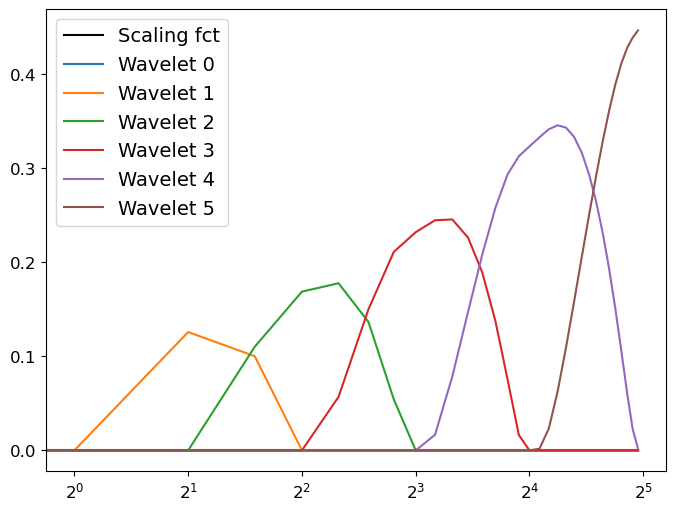

In [3]:
filters = filters_directional_vectorised(L, N, J_min)
wlm, slm = filters
# Plot the filters
plot.plot_filters(filters, real=True, m=L-3)


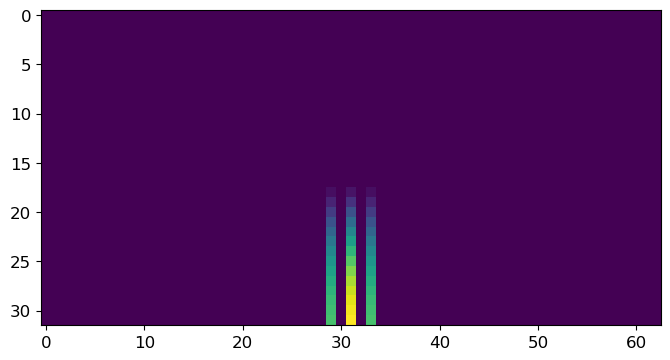

In [4]:
j = 5
plt.figure(figsize=(8, 8))
plt.imshow(np.real(wlm[j, :, :]))

In [14]:
reload(plot)
j = 4
# Make a map
w = s2fft.inverse_jax(wlm[j, :, :], L=L)
print(w.shape)

# Plot the wavelet on the sphere

plot.plot_sphere(w, L, sampling, isnotebook=True)

(32, 63)


Widget(value="<iframe src='http://localhost:36969/index.html?ui=P_0x7fb3106ebf70_0&reconnect=auto' style='widt…

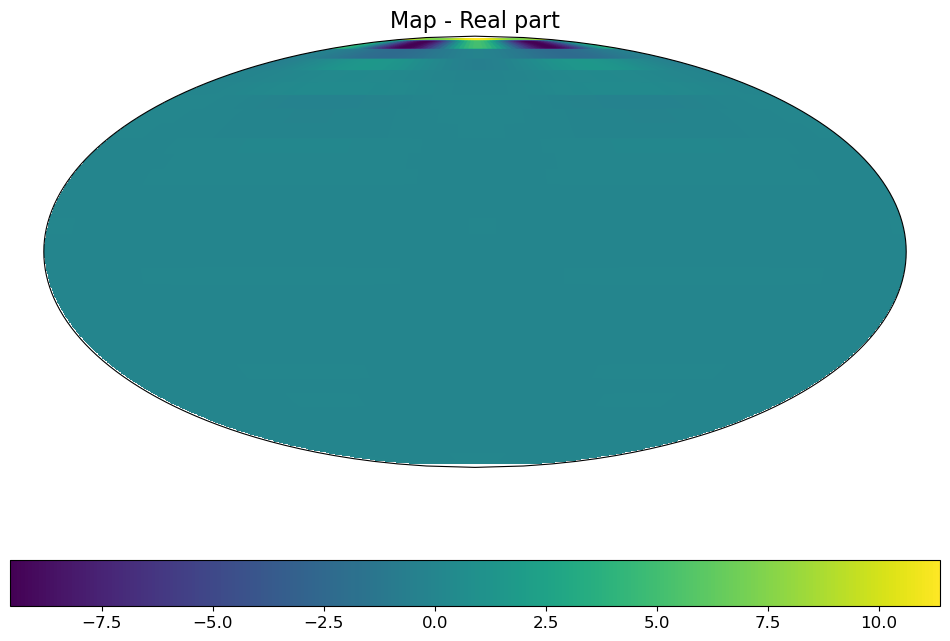

In [12]:
reload(plot)
plot.plot_map_MW_Mollweide(w)

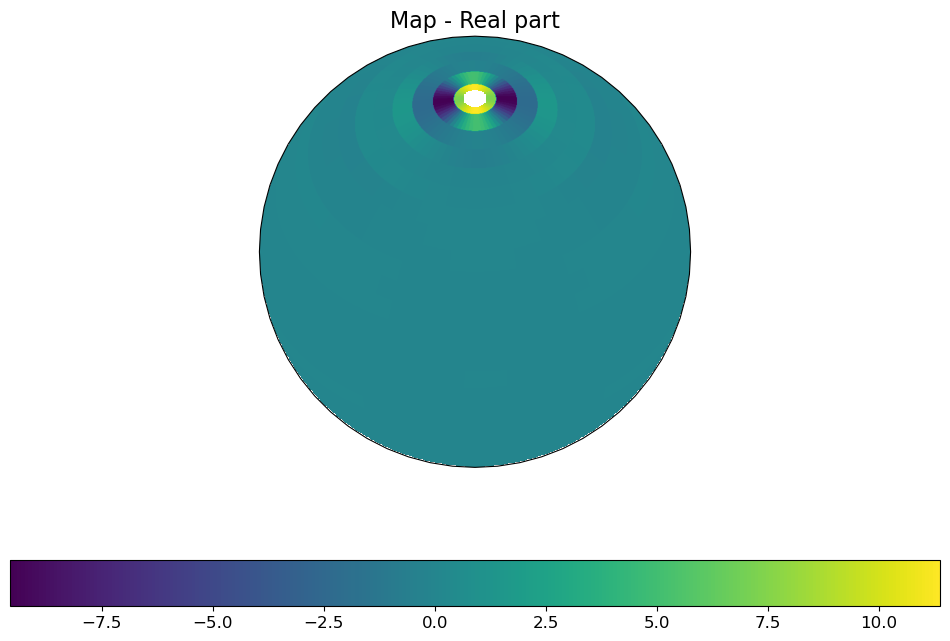

In [15]:
plot.plot_map_MW_Orthographic(w, central_latitude=45)